In [1]:
%%capture 
!pip install super-gradients==3.2.0
!pip install pytube --upgrade
!pip install -q supervision
!pip install onemetric

In [2]:
import os
import yaml
import numpy as np
import random
import cv2
random.seed(10)
from IPython.display import clear_output
    
# Evaluate trained model
def test_model(model,trainer, test_data, dataset_params):
    test_metrics = DetectionMetrics_050(score_thres=0.1, top_k_predictions=300,
                                        num_cls=len(dataset_params['classes']),
                                        normalize_targets=True,
                                        post_prediction_callback=PPYoloEPostPredictionCallback(
                                            score_threshold=0.01, nms_top_k=1000,
                                            max_predictions=300, nms_threshold=0.7))
    return trainer.test(model=model, test_loader=test_data, test_metrics_list=[test_metrics])

# inference predictions on test images 
def perform_inference(model, test_images_dir, test_labels_dir, data_yaml_path, confidence_threshold):
    ds = sv.DetectionDataset.from_yolo(
        images_directory_path=test_images_dir,
        annotations_directory_path=test_labels_dir,
        data_yaml_path=data_yaml_path,
        force_masks=False
    )

    predictions = {}

    for image_name, image in ds.images.items():
        result = list(model.predict(image, conf=confidence_threshold))[0]
        detections = sv.Detections(
            xyxy=result.prediction.bboxes_xyxy,
            confidence=result.prediction.confidence,
            class_id=result.prediction.labels.astype(int)
        )
        predictions[image_name] = detections

    clear_output()

    return ds,predictions

# visualize annotations 
def visualize_annotations_and_predictions(ds, predictions, max_image_count=5):
    keys = list(ds.images.keys())
    keys = random.sample(keys, min(max_image_count, len(ds.images)))

    box_annotator = sv.BoxAnnotator()

    images = []
    titles = []

    for key in keys:
        frame_with_annotations = box_annotator.annotate(
            scene=ds.images[key].copy(),
            detections=ds.annotations[key],
            skip_label=False
        )
        images.append(frame_with_annotations)
        titles.append('annotations')
        frame_with_predictions = box_annotator.annotate(
            scene=ds.images[key].copy(),
            detections=predictions[key],
            skip_label=False
        )
        images.append(frame_with_predictions)
        titles.append('predictions')

    %matplotlib inline
    sv.plot_images_grid(images=images, titles=titles, grid_size=(len(keys), 2), size=(2 * 4, len(keys) * 4))
    
def create_and_plot_confusion_matrix(ds, predictions, confidence_threshold, output_path):
    keys = list(ds.images.keys())

    annotation_batches, prediction_batches = [], []

    for key in keys:
        annotation = ds.annotations[key]
        annotation_batch = np.column_stack((
            annotation.xyxy,
            annotation.class_id
        ))
        annotation_batches.append(annotation_batch)

        prediction = predictions[key]
        prediction_batch = np.column_stack((
            prediction.xyxy,
            prediction.class_id,
            prediction.confidence
        ))
        prediction_batches.append(prediction_batch)

    confusion_matrix = ConfusionMatrix.from_detections(
        true_batches=annotation_batches,
        detection_batches=prediction_batches,
        num_classes=len(ds.classes),
        conf_threshold=confidence_threshold
    )

    confusion_matrix.plot(output_path, class_names=ds.classes)


In [3]:
%%capture
import supervision as sv
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from onemetric.cv.object_detection import ConfusionMatrix

In [4]:
yaml_path = "/kaggle/input/football-dataset-for-object-detection/data.yaml"
data_dir = '/kaggle/input/football-dataset-for-object-detection'

# Load YAML data
with open(yaml_path, 'r') as yaml_file:
        yaml_data = yaml.load(yaml_file, Loader=yaml.FullLoader)
        
#Global parameters
BATCH_SIZE= 16
EPOCHS= 10
WORKERS= 2
CONFIDENCE_TRESHOLD = 0.5
MODEL_ARCH = 'yolo_nas_l'
CHECKPOINT_DIR = '/kaggle/working/checkpoints'
EXPEREMENT_NAME = f"{EPOCHS}_epoch_trian"

# Create dataset and dataloader parameters
dataset_params = {
    'data_dir':data_dir,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': yaml_data['names']
}

dataloader_params = {
    'batch_size': BATCH_SIZE,
    'num_workers': WORKERS
}

trainer = Trainer(experiment_name=EXPEREMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [5]:
# Create train & val loaders
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params=dataloader_params
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params=dataloader_params
)

Indexing dataset annotations: 100%|██████████| 1276/1276 [00:21<00:00, 60.49it/s]


# Model Training

In [6]:
# Load and configure the YOLO model
model = models.get(MODEL_ARCH, num_classes=len(dataset_params['classes']), pretrained_weights="coco")

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:01<00:00, 220MB/s]


In [7]:
# Define train params and train the YOLO model
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}



In [8]:
# Train YOLO model
trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

[2023-09-01 14:26:18] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-01 14:26:30] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Dataset size:                 10212      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         638        (len(train_loader))
    - Gradient updates per epoch:   638        (len(train_loader) / batch_accumulate)

[2023-09-01 15:01:05] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/checkpoints/10_epoch_trian/ckpt_best.pth
[2023-09-01 15:01:05] INFO - sg_trainer.py - Best checkpoint over

In [9]:
# Transforms and Augmentations
# train_data.dataset.transforms

# Test Best Model

In [10]:
# Test Data Loader
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params=dataloader_params
)

[2023-09-01 20:16:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1276/1276 [00:22<00:00, 55.92it/s]


In [11]:
# Load the best model
best_model = models.get(MODEL_ARCH, num_classes=len(dataset_params['classes']),
                             checkpoint_path=f"{CHECKPOINT_DIR}/{EXPEREMENT_NAME}/average_model.pth")

[2023-09-01 20:16:49] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/checkpoints/10_epoch_trian/average_model.pth EMA checkpoint.


In [12]:
# Test the model
test_results=test_model(best_model,trainer, test_data, dataset_params)
print(test_results)

Testing: 100%|██████████| 79/79 [01:27<00:00,  1.10s/it]


{'PPYoloELoss/loss_cls': 0.53186107, 'PPYoloELoss/loss_iou': 0.12669995, 'PPYoloELoss/loss_dfl': 0.6044319, 'PPYoloELoss/loss': 1.1508267, 'Precision@0.50': 0.19856972992420197, 'Recall@0.50': 0.9130477905273438, 'mAP@0.50': 0.8257177472114563, 'F1@0.50': 0.3102313280105591}


In [13]:
# inference predictions on test images 
ds,inference_predictions = perform_inference(best_model,
                                             os.path.join(data_dir,dataset_params['test_images_dir']),
                                             os.path.join(data_dir,dataset_params['test_labels_dir']), 
                                             yaml_path, CONFIDENCE_TRESHOLD)

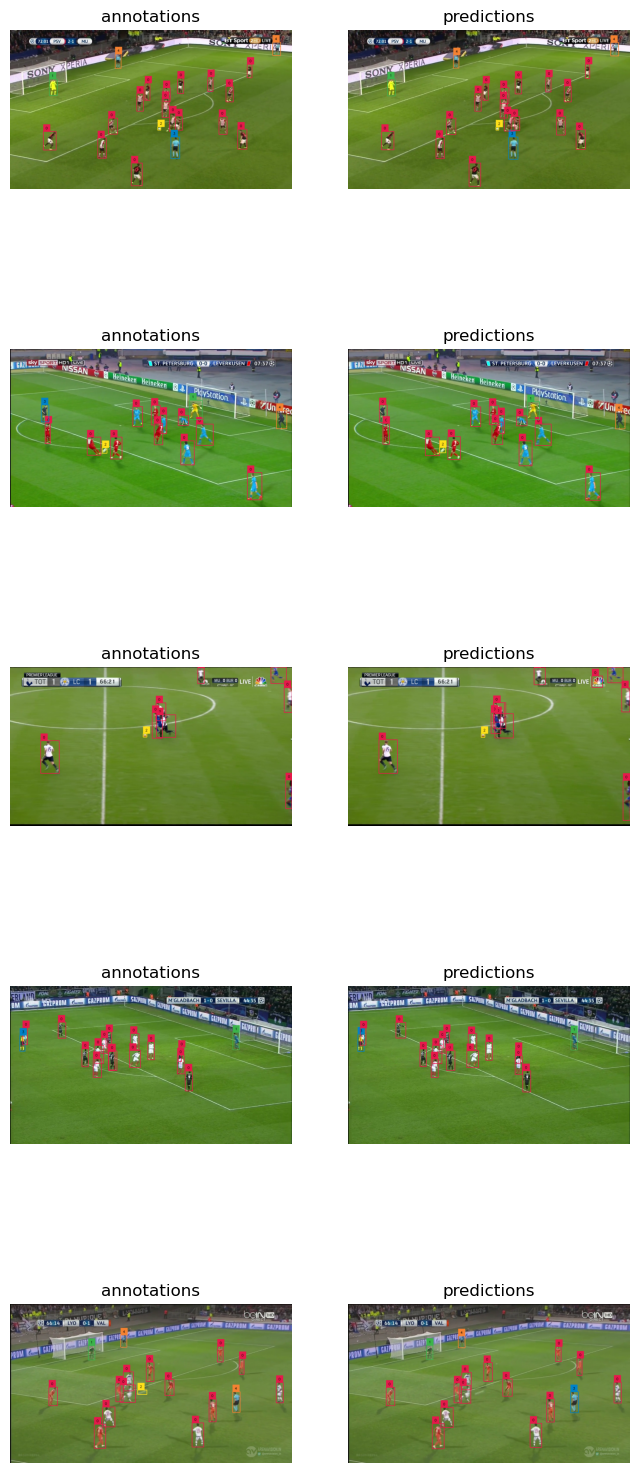

In [14]:
# visualize annotations 
visualize_annotations_and_predictions(ds, inference_predictions, max_image_count=5)

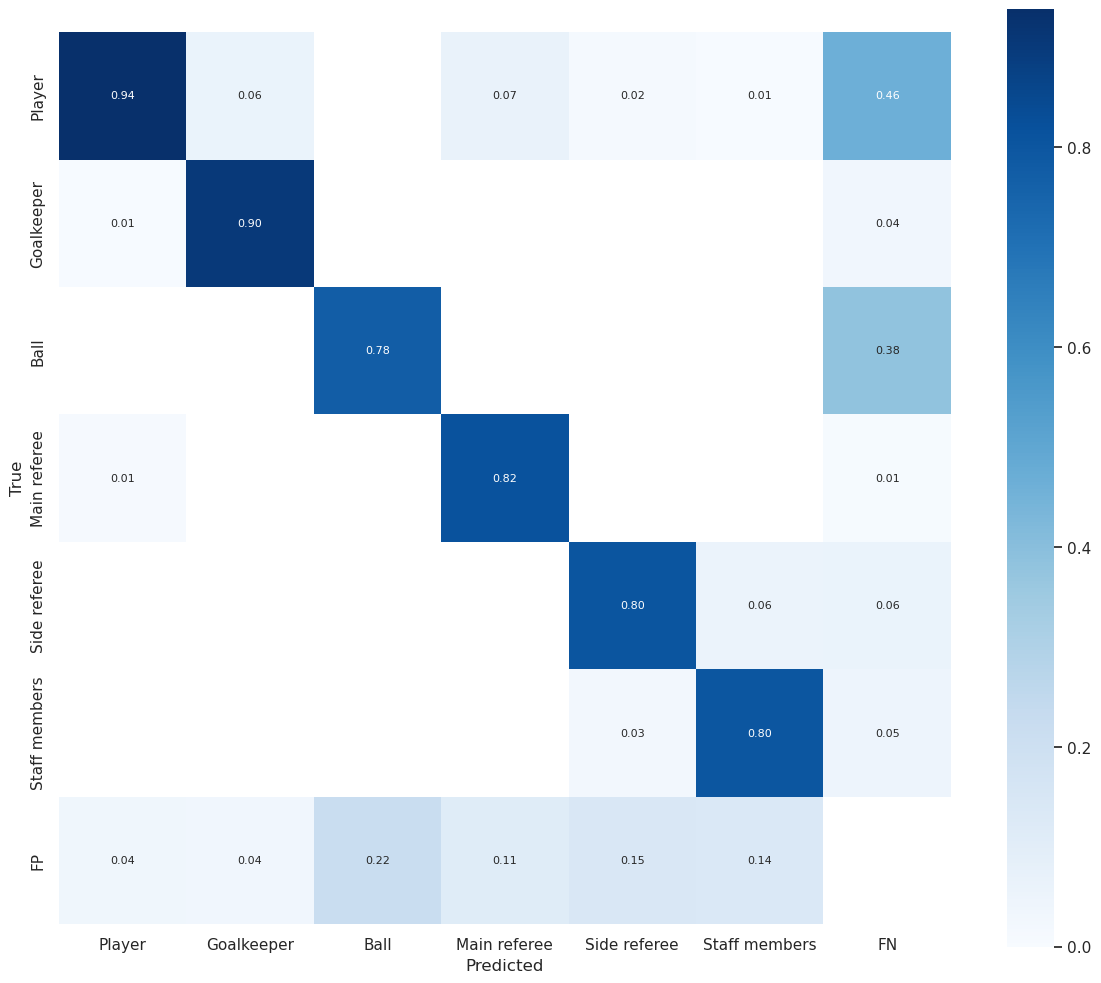

In [15]:
# show confusion matrix
create_and_plot_confusion_matrix(ds, inference_predictions, CONFIDENCE_TRESHOLD, "/kaggle/working/confusion_matrix.png")

In [16]:
# import torch
# device = 'cuda' if torch.cuda.is_available() else "cpu"
# output predition on videos
# model.to(device).predict(input_video_path,conf=CONFIDENCE_TRESHOLD).save(output_video_path)